### Solar Universe R&D 
- Objectives: Implement pix2pix GAN on dataset

#### Todo:
- generator.py merge_mode = 'concat' shape issue 
- Batchnormalization mode=2 was removed, couldnt find alternative to it
- Virtual env?


In [8]:
import numpy as np
from skimage import io
import os
import glob

def show(img):
    io.imshow(img)
    io.show()

In [10]:
imglst = sorted(glob.glob('../images20171212/*'))
lablst = sorted(glob.glob('../images_label_w_ridges20171212/*'))

In [11]:
x = io.imread(imglst[0])
y = io.imread(lablst[0])

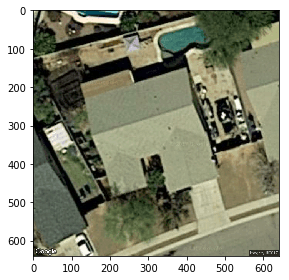

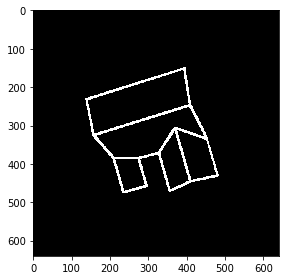

(None, None)

In [12]:
show(x),show(y==3)

In [13]:
yr = (y==3).astype(int)

/home/irtza/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


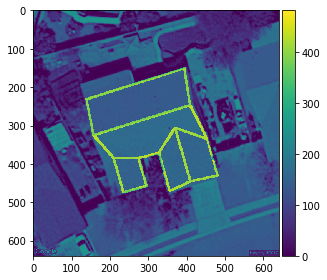

In [14]:
t = x[:,:,0] + (yr*255.0)
show(t)

# formulation as a generative modelling roof to ridges.

- X  = input image with some ridges as identified by the eye. 
- yr = We have an image of ridges. 
- pols = We have the polygons of the image ridges. 

#### Pix to pix Algorithm. GANs

- Image to Image Translation. 
Sat -> Nav
Sat -> Ridges

Pytorch Implementation 
https://github.com/Irtza/pytorch-CycleGAN-and-pix2pix

This Notebook is authored by github.com/irtza for RePower.Solar and Red-Buffer
train.py 

### CycleGAN train/test
- Download a CycleGAN dataset (e.g. maps):
```bash
bash ./datasets/download_cyclegan_dataset.sh maps
```
- Train a model:
```bash
#!./scripts/train_cyclegan.sh
python train.py --dataroot ./datasets/maps --name maps_cyclegan --model cycle_gan --no_dropout
```
- To view training results and loss plots, run `python -m visdom.server` and click the URL http://localhost:8097. To see more intermediate results, check out `./checkpoints/maps_cyclegan/web/index.html`
- Test the model:
```bash
#!./scripts/test_cyclegan.sh
python test.py --dataroot ./datasets/maps --name maps_cyclegan --model cycle_gan --phase test --no_dropout
```
The test results will be saved to a html file here: `./results/maps_cyclegan/latest_test/index.html`.

### pix2pix train/test
- Download a pix2pix dataset (e.g.facades):
```bash
bash ./datasets/download_pix2pix_dataset.sh facades
```
- Train a model:
```bash
#!./scripts/train_pix2pix.sh
python train.py --dataroot ./datasets/facades --name facades_pix2pix --model pix2pix --which_model_netG unet_256 --which_direction BtoA --lambda_A 100 --dataset_mode aligned --no_lsgan --norm batch --pool_size 0
```
- To view training results and loss plots, run `python -m visdom.server` and click the URL http://localhost:8097. To see more intermediate results, check out  `./checkpoints/facades_pix2pix/web/index.html`
- Test the model (`bash ./scripts/test_pix2pix.sh`):
```bash
#!./scripts/test_pix2pix.sh
python test.py --dataroot ./datasets/facades --name facades_pix2pix --model pix2pix --which_model_netG unet_256 --which_direction BtoA --dataset_mode aligned --norm batch
```
The test results will be saved to a html file here: `./results/facades_pix2pix/latest_val/index.html`.

More example scripts can be found at `scripts` directory.

### Apply a pre-trained model (CycleGAN)

If you would like to apply a pre-trained model to a collection of input photos (without image pairs), please use `--dataset_mode single` and `--model test` options. Here is a script to apply a model to Facade label maps (stored in the directory `facades/testB`).
``` bash
#!./scripts/test_single.sh
python test.py --dataroot ./datasets/facades/testA/ --name {my_trained_model_name} --model test --dataset_mode single
```
You might want to specify `--which_model_netG` to match the generator architecture of the trained model.

You can download a few pretrained models from the authors. For example, if you would like to download horse2zebra model, 

```bash
bash pretrained_models/download_cyclegan_model.sh horse2zebra
```
The pretrained model is saved at `./checkpoints/{name}_pretrained/latest_net_G.pth`. 
Then generate the results using

```bash
python test.py --dataroot datasets/horse2zebra/testA --checkpoints_dir ./checkpoints/ --name horse2zebra_pretrained --no_dropout --model test --dataset_mode single --loadSize 256 --results_dir {directory_path_to_save_result}
```

Note: We currently don't have all pretrained models using PyTorch. This is in part because the models trained using Torch and PyTorch produce slightly different results, although we were not able to decide which result is better. If you would like to generate the same results that appeared in our paper, we recommend using the pretrained models in the Torch codebase. 

### Apply a pre-trained model (pix2pix)

Download the pre-trained models using `./pretrained_models/download_pix2pix_model.sh`. For example, if you would like to download label2photo model on the Facades dataset,

```bash
bash pretrained_models/download_pix2pix_model.sh facades_label2photo
```

Then generate the results using
```bash
python test.py --dataroot ./datasets/facades/ --which_direction BtoA --model pix2pix --name facades_label2photo_pretrained --dataset_mode aligned --which_model_netG unet_256 --norm batch
```
Note that we specified `--which_direction BtoA` to accomodate the fact that the Facades dataset's A to B direction is photos to labels.

Also, the models that are currently available to download can be found by reading the output of `bash pretrained_models/download_pix2pix_model.sh`

## Training/test Details
- Flags: see `options/train_options.py` and `options/base_options.py` for all the training flags; see `options/test_options.py` and `options/base_options.py` for all the test flags.
- CPU/GPU (default `--gpu_ids 0`): set`--gpu_ids -1` to use CPU mode; set `--gpu_ids 0,1,2` for multi-GPU mode. You need a large batch size (e.g. `--batchSize 32`) to benefit from multiple GPUs.  
- Visualization: during training, the current results can be viewed using two methods. First, if you set `--display_id` > 0, the results and loss plot will appear on a local graphics web server launched by [visdom](https://github.com/facebookresearch/visdom). To do this, you should have `visdom` installed and a server running by the command `python -m visdom.server`. The default server URL is `http://localhost:8097`. `display_id` corresponds to the window ID that is displayed on the `visdom` server. The `visdom` display functionality is turned on by default. To avoid the extra overhead of communicating with `visdom` set `--display_id 0`. Second, the intermediate results are saved to `[opt.checkpoints_dir]/[opt.name]/web/` as an HTML file. To avoid this, set `--no_html`.
- Preprocessing: images can be resized and cropped in different ways using `--resize_or_crop` option. The default option `'resize_and_crop'` resizes the image to be of size `(opt.loadSize, opt.loadSize)` and does a random crop of size `(opt.fineSize, opt.fineSize)`. `'crop'` skips the resizing step and only performs random cropping. `'scale_width'` resizes the image to have width `opt.fineSize` while keeping the aspect ratio. `'scale_width_and_crop'` first resizes the image to have width `opt.loadSize` and then does random cropping of size `(opt.fineSize, opt.fineSize)`.
- Fine-tuning/Resume training: to fine-tune a pre-trained model, or resume the previous training, use the `--continue_train` flag. The program will then load the model based on `which_epoch`. By default, the program will initialize the epoch count as 1. Set `--epoch_count <int>` to specify a different starting epoch count.


### CycleGAN Datasets
Download the CycleGAN datasets using the following script. Some of the datasets are collected by other researchers. Please cite their papers if you use the data.
```bash
bash ./datasets/download_cyclegan_dataset.sh dataset_name
```
- `facades`: 400 images from the [CMP Facades dataset](http://cmp.felk.cvut.cz/~tylecr1/facade). [[Citation](datasets/bibtex/facades.tex)]
- `cityscapes`: 2975 images from the [Cityscapes training set](https://www.cityscapes-dataset.com). [[Citation](datasets/bibtex/cityscapes.tex)]
- `maps`: 1096 training images scraped from Google Maps.
- `horse2zebra`: 939 horse images and 1177 zebra images downloaded from [ImageNet](http://www.image-net.org) using keywords `wild horse` and `zebra`
- `apple2orange`: 996 apple images and 1020 orange images downloaded from [ImageNet](http://www.image-net.org) using keywords `apple` and `navel orange`.
- `summer2winter_yosemite`: 1273 summer Yosemite images and 854 winter Yosemite images were downloaded using Flickr API. See more details in our paper.
- `monet2photo`, `vangogh2photo`, `ukiyoe2photo`, `cezanne2photo`: The art images were downloaded from [Wikiart](https://www.wikiart.org/). The real photos are downloaded from Flickr using the combination of the tags *landscape* and *landscapephotography*. The training set size of each class is Monet:1074, Cezanne:584, Van Gogh:401, Ukiyo-e:1433, Photographs:6853.
- `iphone2dslr_flower`: both classes of images were downlaoded from Flickr. The training set size of each class is iPhone:1813, DSLR:3316. See more details in our paper.

To train a model on your own datasets, you need to create a data folder with two subdirectories `trainA` and `trainB` that contain images from domain A and B. You can test your model on your training set by setting `--phase train` in `test.py`. You can also create subdirectories `testA` and `testB` if you have test data.

You should **not** expect our method to work on just any random combination of input and output datasets (e.g. `cats<->keyboards`). From our experiments, we find it works better if two datasets share similar visual content. For example, `landscape painting<->landscape photographs` works much better than `portrait painting <-> landscape photographs`. `zebras<->horses` achieves compelling results while `cats<->dogs` completely fails.

### pix2pix datasets
Download the pix2pix datasets using the following script. Some of the datasets are collected by other researchers. Please cite their papers if you use the data.
```bash
bash ./datasets/download_pix2pix_dataset.sh dataset_name
```
- `facades`: 400 images from [CMP Facades dataset](http://cmp.felk.cvut.cz/~tylecr1/facade). [[Citation](datasets/bibtex/facades.tex)]
- `cityscapes`: 2975 images from the [Cityscapes training set](https://www.cityscapes-dataset.com). [[Citation](datasets/bibtex/cityscapes.tex)]
- `maps`: 1096 training images scraped from Google Maps
- `edges2shoes`: 50k training images from [UT Zappos50K dataset](http://vision.cs.utexas.edu/projects/finegrained/utzap50k). Edges are computed by [HED](https://github.com/s9xie/hed) edge detector + post-processing. [[Citation](datasets/bibtex/shoes.tex)]
- `edges2handbags`: 137K Amazon Handbag images from [iGAN project](https://github.com/junyanz/iGAN). Edges are computed by [HED](https://github.com/s9xie/hed) edge detector + post-processing. [[Citation](datasets/bibtex/handbags.tex)]

We provide a python script to generate pix2pix training data in the form of pairs of images {A,B}, where A and B are two different depictions of the same underlying scene. For example, these might be pairs {label map, photo} or {bw image, color image}. Then we can learn to translate A to B or B to A:

Create folder `/path/to/data` with subfolders `A` and `B`. `A` and `B` should each have their own subfolders `train`, `val`, `test`, etc. In `/path/to/data/A/train`, put training images in style A. In `/path/to/data/B/train`, put the corresponding images in style B. Repeat same for other data splits (`val`, `test`, etc).

Corresponding images in a pair {A,B} must be the same size and have the same filename, e.g., `/path/to/data/A/train/1.jpg` is considered to correspond to `/path/to/data/B/train/1.jpg`.

Once the data is formatted this way, call:
```bash
python datasets/combine_A_and_B.py --fold_A /path/to/data/A --fold_B /path/to/data/B --fold_AB /path/to/data
```

This will combine each pair of images (A,B) into a single image file, ready for training.

## Citation
If you use this code for your research, please cite our papers.
```
@article{CycleGAN2017,
  title={Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks},
  author={Zhu, Jun-Yan and Park, Taesung and Isola, Phillip and Efros, Alexei A},
  journal={arXiv preprint arXiv:1703.10593},
  year={2017}
}

@article{pix2pix2016,
  title={Image-to-Image Translation with Conditional Adversarial Networks},
  author={Isola, Phillip and Zhu, Jun-Yan and Zhou, Tinghui and Efros, Alexei A},
  journal={arxiv},
  year={2016}
}
```

## Related Projects
[CycleGAN](https://github.com/junyanz/CycleGAN): Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks  
[pix2pix](https://github.com/phillipi/pix2pix): Image-to-image translation with conditional adversarial nets  
[iGAN](https://github.com/junyanz/iGAN): Interactive Image Generation via Generative Adversarial Networks

## Cat Paper Collection
If you love cats, and love reading cool graphics, vision, and learning papers, please check out the Cat Paper Collection:  
[[Github]](https://github.com/junyanz/CatPapers) [[Webpage]](https://people.eecs.berkeley.edu/~junyanz/cat/cat_papers.html)

## Acknowledgments
Code is inspired by [pytorch-DCGAN](https://github.com/pytorch/examples/tree/master/dcgan).


In [17]:
import time
from options.train_options import TrainOptions

from data.data_loader import CreateDataLoader
## Figure out the Data Loading Representations and feed in our own data. 

from models.models import create_model
from util.visualizer import Visualizer

In [18]:
opt = TrainOptions().parse()
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training images = %d' % dataset_size)

model = create_model(opt)
visualizer = Visualizer(opt)
total_steps = 0

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    epoch_iter = 0

    for i, data in enumerate(dataset):
        iter_start_time = time.time()
        visualizer.reset()
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize
        model.set_input(data)
        model.optimize_parameters()

        if total_steps % opt.display_freq == 0:
            save_result = total_steps % opt.update_html_freq == 0
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_steps % opt.print_freq == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batchSize
            visualizer.print_current_errors(epoch, epoch_iter, errors, t)
            if opt.display_id > 0:
                visualizer.plot_current_errors(epoch, float(epoch_iter)/dataset_size, opt, errors)

        if total_steps % opt.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_steps %d)' %
                  (epoch, total_steps))
            model.save('latest')

    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' %
              (epoch, total_steps))
        model.save('latest')
        model.save(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()


usage: ipykernel_launcher.py [-h] --dataroot DATAROOT [--batchSize BATCHSIZE]
                             [--loadSize LOADSIZE] [--fineSize FINESIZE]
                             [--input_nc INPUT_NC] [--output_nc OUTPUT_NC]
                             [--ngf NGF] [--ndf NDF]
                             [--which_model_netD WHICH_MODEL_NETD]
                             [--which_model_netG WHICH_MODEL_NETG]
                             [--n_layers_D N_LAYERS_D] [--gpu_ids GPU_IDS]
                             [--name NAME] [--dataset_mode DATASET_MODE]
                             [--model MODEL]
                             [--which_direction WHICH_DIRECTION]
                             [--nThreads NTHREADS]
                             [--checkpoints_dir CHECKPOINTS_DIR] [--norm NORM]
                             [--serial_batches]
                             [--display_winsize DISPLAY_WINSIZE]
                             [--display_id DISPLAY_ID]
                             [-

SystemExit: 2

/home/irtza/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
